Import libraries.

In [26]:
import pymongo
import footmldb as fdb
import pandas as pd
from pandas.io.json import json_normalize
import json

In [68]:
def connect_db(remote=False):
    """
    Connects to learnbet database and returns the database object.
    
    If remote=True this method will connect to the live database on the aws server.
    Work carefully with it, db is live.
    """
    
    if remote:
        with open("db_credentials_remote.json", "r") as file:
            db_config = json.load(file)
    else:
        with open("db_credentials.json", "r") as file:
            db_config = json.load(file)
            
    uri = 'mongodb://%s:%s@%s/%s' % \
          (db_config['username'], 
           db_config['password'], 
           db_config['DB_IP'], 
           db_config['DB_name'])
    
    client = pymongo.MongoClient(uri)
    db = client.get_database()
    
    return db

In [73]:
db_ = connect_db(remote=True)

In [74]:
print(db_.matches.count())

C:\Users\mp3213\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


542


In [75]:
m = db_.matches.find_one({'team_home': 'Inter Milan', 'team_away': 'Barcelona'})
all_odds = m['all_odds']['winner']
for entry in all_odds:
    print("%s | %d " % (entry['datetime'], len(entry['odds'])))

2018-10-30 14:50:42.137000 | 22 
2018-10-30 16:59:49.471000 | 24 
2018-10-30 20:59:37.782000 | 25 
2018-10-30 23:08:09.870000 | 25 
2018-10-31 02:43:11.660000 | 25 
2018-10-31 03:01:43.421000 | 25 
2018-10-31 04:42:15.770000 | 25 
2018-10-31 05:04:10.399000 | 25 
2018-10-31 08:43:08.060000 | 25 
2018-10-31 09:13:00.534000 | 25 
2018-10-31 10:35:07.684000 | 24 
2018-10-31 11:02:55.697000 | 25 
2018-10-31 14:43:11.292000 | 25 
2018-10-31 15:11:00.724000 | 25 
2018-10-31 16:33:38.289000 | 25 
2018-10-31 17:09:19.557000 | 25 
2018-10-31 20:38:19.803000 | 25 
2018-10-31 20:38:47.768000 | 25 
2018-10-31 21:14:40.671000 | 25 
2018-10-31 21:15:07.991000 | 25 
2018-10-31 22:49:16.370000 | 25 
2018-10-31 23:06:31.464000 | 25 
2018-11-01 02:31:45.166000 | 25 
2018-11-01 02:32:15.619000 | 25 
2018-11-01 03:04:14.670000 | 25 
2018-11-01 06:33:28.434000 | 25 
2018-11-01 06:33:55.273000 | 25 
2018-11-01 07:05:03.496000 | 25 
2018-11-01 10:47:01.343000 | 25 
2018-11-01 10:47:29.005000 | 25 
2018-11-01

# Get matches (list / dataframe)

Get all matches.

In [52]:
def get_db_matches():
    """
    Get a list of all matches from db
    """
    
    # Get matches from db, sorted by `match_datetime`
    db_ = connect_remote_db()
    ms = list(db_.matches.find())  # .sort("match_datetime")
    return ms


def get_matches_df():
    """
    Get a pandas dataframe of all matches in db
    """
    
    ms = get_db_matches()
    df_orig = json_normalize(ms)
    df = df_orig
    df['goals_home'] = df['result.fulltime.goals_home']
    df['goals_away'] = df['result.fulltime.goals_away']
    df = df.drop(['odds_link', '_id', 'result.extratime.goals_away', 'result.extratime.goals_home', 'result.halftime.goals_away', 'result.halftime.goals_home', 'result.fulltime.goals_away', 'result.fulltime.goals_home'], axis=1)
    df['num_odds'] = [len(a) for a in df['all_odds.winner']]
    return df

In [ ]:
df = get_matches_df()
len(df)

Print a few matches:

Get one match and analyse it.

# Get bookies stats

Using the `get_bookie_stats` method, I can see bookies' activity and choose the most active ones to get data from.

In [60]:
def get_bookie_stats():

    from collections import Counter
    ms = get_db_matches()

    bookies_count = {}
    bookies_list_global = []

    for m in ms:

        # Go through all odds and create a set of unique bookies appearing in each match
        bookies_set = set()
        all_odds = m['all_odds']['winner']
        print(all_odds)
        all_odds = [item for item in all_odds if item is not None]
        all_odds = sorted(all_odds, key=lambda item:item['datetime'])
        for entry in all_odds:
            bookies_list = [e['bookie'] for e in entry['odds']]
            bookies_set.update(bookies_list)
            bookies_list_global.extend(bookies_list)

        # Update bookie appearance count for all matches
        for bookie in bookies_set:
            if bookie in bookies_count.keys():
                bookies_count[bookie] += 1
            else:
                bookies_count[bookie] = 1

    # Get bookies from most to least common appearances
    counter_all_appear = Counter(bookies_list_global)
    
    dict_all = {}
    dict_all['match_appear'] = bookies_count
    dict_all['all_appear'] = counter_all_appear
    
    df = pd.DataFrame(dict_all)
    df.sort_values(by='match_appear', inplace=True, ascending=False)
    return df


In [61]:
df = get_bookie_stats()
df

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TypeError: 'NoneType' object is not iterable

In [199]:
df = get_bookie_stats()
df

,all_appear,match_appear
Bet 365,12831,902
Sky Bet,11390,851
Ladbrokes,10396,826
William Hill,9985,802
Marathon Bet,9537,780
Betfair Sportsbook,9314,770
SunBets,9176,764
Paddy Power,9056,751
Unibet,8967,748
Coral,8848,743


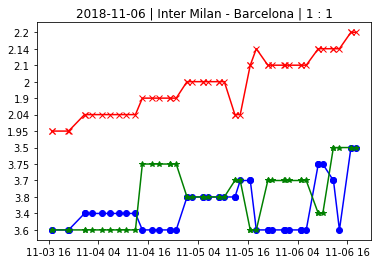

In [45]:
m = db.matches.find_one({'team_home': 'Inter Milan', 'team_away': 'Barcelona'})

winner = m['all_odds']['winner']
odds_bet365 = []
for odds in winner:
    for odd in odds['odds']:
        if odd['bookie'] == 'Bet 365':
            odd['datetime'] = odds['datetime']
            odds_bet365.append(odd)
            


# print(odds_bet365)

import matplotlib.pyplot as plt

dates = [a['datetime'] for a in odds_bet365]
home_win = [a['1'] for a in odds_bet365]
away_win = [a['2'] for a in odds_bet365]
draw = [a['0'] for a in odds_bet365]

plt.title("%s | %s - %s | %s" % (str(m['match_datetime'])[:-9], m['team_home'], m['team_away'], m['result']['score']))
plt.plot(dates, home_win, "-o", color='blue')
plt.plot(dates, away_win, "-x", color='red')
plt.plot(dates, draw, "-*", color='green')
plt.show()

## Update Oct 2018

In [6]:
df = get_bookie_stats()

OperationFailure: Executor error during find command: OperationFailed: Sort operation used more than the maximum 33554432 bytes of RAM. Add an index, or specify a smaller limit.